In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
import glob
import os

In [5]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [6]:
# Boundind Box 좌표 정보가 담긴 csv 파일

df_train_anger = pd.read_csv(json_path_train + 'train_anger_1.csv')
df_val_anger = pd.read_csv (json_path_val + 'val_anger.csv')

df_train_happy = pd.read_csv(json_path_train + 'train_happy_1.csv')
df_val_happy = pd.read_csv (json_path_val + 'val_happy.csv')

df_train_panic = pd.read_csv(json_path_train + 'train_panic_1.csv')
df_val_panic = pd.read_csv (json_path_val + 'val_panic.csv')

df_train_sadness = pd.read_csv(json_path_train + 'train_sadness_1.csv')
df_val_sadness = pd.read_csv (json_path_val + 'val_sadness.csv')


#### 데이터 증강
- Albumentation

    - `A.Resize(640,640)` : 이미지 크기 조정
    - `A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7)` : 이미지 확대, 평행 이동, 기울임
    - `A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5)` : 이미지 평행 이동, 회전
    - `A.ElasticTransform(alpha=1, sigma=50, p=0.3)` : 이미지 왜곡 (옆모습 등)
    - `A.HorizontalFlip(p=0.5)` : 이미지 좌우 반전
    - `A.RandomBrightnessContrast(p=0.2)` : 이미지 밝기/대비 조정

In [7]:
processed_data = []

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/anger/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_anger.csv'
# input_dir = img_path_train_anger
# df = df_train_anger

output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/happy/'
output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_happy.csv'
input_dir = img_path_train_happy
df = df_train_happy

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/panic/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_panic.csv'
# input_dir = img_path_train_panic
# df = df_train_panic

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/sadness/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_sadness.csv'
# input_dir = img_path_train_sadness
# df = df_train_sadness

# 가져온 이미지 파일들 출력
for index, row in df.iterrows():
    # 이미지와 바운딩 박스를 정의 (예: [x_min, y_min, x_max, y_max])
    image = cv2.imread(input_dir + row['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 바운딩 박스 좌표 (예시)
    bboxes = [
        [row['annot_A.boxes.minX'], row['annot_A.boxes.minY'], row['annot_A.boxes.maxX'], row['annot_A.boxes.maxY']],
        [row['annot_B.boxes.minX'], row['annot_B.boxes.minY'], row['annot_B.boxes.maxX'], row['annot_B.boxes.maxY']],
        [row['annot_C.boxes.minX'], row['annot_C.boxes.minY'], row['annot_C.boxes.maxX'], row['annot_C.boxes.maxY']],
        [row['avg_box.minX'], row['avg_box.minY'], row['avg_box.maxX'], row['avg_box.maxY']],
            
    ]  # 각 박스는 [x_min, y_min, x_max, y_max]
    category_ids = [1, 2, 3, 4]  # 각 바운딩 박스에 대응하는 카테고리 ID

    # 변환 파이프라인 정의 (이미지 및 바운딩 박스)
    transform = A.Compose(
        [
            A.Resize(640, 640),  # 크기 조정
            A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7), # 확대, 평행 이동, 기울임
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5), # 평행 이동, 회전
            A.ElasticTransform(alpha=1, sigma=50, p=0.3), # 왜곡(뒤틀림)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기
            A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 조정
        ], 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_id'])
    )

    # 변환 수행
    augmented = transform(image=image, bboxes=bboxes, category_id=category_ids)

    # 변환된 이미지 및 바운딩 박스
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']

    # 바운딩 박스 중 가장 큰 영역만 남기기
    # 면적 계산: (x_max - x_min) * (y_max - y_min)
    def get_largest_bbox(bboxes):
        largest_bbox = None
        largest_area = 0
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            area = (x_max - x_min) * (y_max - y_min)
            if area > largest_area:
                largest_area = area
                largest_bbox = bbox
        return largest_bbox
    
    # largest_bbox = get_largest_bbox(augmented_bboxes)
    # x_min, y_min, x_max, y_max = largest_bbox

    # 바운딩 박스 확인
    if not augmented_bboxes:
        print("No bounding boxes found after augmentation.")
    else:
        # 가장 큰 바운딩 박스만 남기기
        largest_bbox = get_largest_bbox(augmented_bboxes)

        if largest_bbox is None:
            print("No valid bounding boxes found.")
        else:
            x_min, y_min, x_max, y_max = largest_bbox
            print(f"Largest bounding box: {x_min}, {y_min}, {x_max}, {y_max}")

    # 처리된 이미지 저장
    os.makedirs(output_dir, exist_ok=True)
    output_path = output_dir + f"albumentation_{row['filename']}"
    cv2.imwrite(output_path, augmented_image)
    print(f"Processed and saved: {output_path}")

    # 변경된 데이터 저장
    processed_data.append({
        'filename': f"albumentation_{row['filename']}",
        'maxX': int(x_max),
        'maxY': int(y_max),
        'minX': int(x_min),
        'minY': int(y_min),
        'faceExp_uploader': row['faceExp_uploader'],
    })

# 처리된 데이터 저장
if processed_data:
    processed_df = pd.DataFrame(processed_data)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    processed_df.to_csv(output_csv_path, index=False)
    print(f"Processed CSV saved to: {output_csv_path}")
else:
    print("No data processed.")



Largest bounding box: 94.82132720947266, 278.9339904785156, 291.1474914550781, 562.741455078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_1ssf46b4695747c6e323bf090389b57049cff58a0851d50d3de8c0dc5ccb7lemg.jpg
Largest bounding box: 352.7115478515625, 139.0515899658203, 601.3585205078125, 534.099365234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_hfbl2d0622517ad6ef5456d1fa4e7d52f57ff1dff320944fe34fade7feb33ns68.jpg
Largest bounding box: 263.05780029296875, 415.7106628417969, 630.124755859375, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_eg9e62a9cfcd9eabbe75c79dd12d99e99cdd9960ba9dafdb798c9776fec77ukjn.jpg
Largest bounding box: 351.3425598144531, 117.77324676513672, 640.0, 513.1304931640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_w0l5595485285b029508299b09d058cb30ebcd2

Invalid SOS parameters for sequential JPEG


Largest bounding box: 157.61248779296875, 289.6819152832031, 349.8598327636719, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_6ne4003796c182ac266f8a61858d6026a90083cc82d58caab54721d8f67e53vgu.jpg
Largest bounding box: 227.0265655517578, 129.91258239746094, 533.5698852539062, 577.8986206054688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_io04f412ee306b212d1d5b2c0762180e50fde2a420b42fda62c22e2ea1a2b7nz1.jpg
Largest bounding box: 186.79405212402344, 31.28269386291504, 366.78045654296875, 435.8487548828125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_7q315677654760b9ed97279824772f6ffa5c6a41f94bf96271e346cb49546xx3k.jpg
Largest bounding box: 321.1606750488281, 227.58799743652344, 584.7894897460938, 585.5863037109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_9oola0b9cb2a33abee76b

Invalid SOS parameters for sequential JPEG


Largest bounding box: 1.0, 387.1900939941406, 131.6672821044922, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_ht5m1b7cf78413f34cb343040047fafcf9471094fa3189331b547c2324939db79.jpg
Largest bounding box: 276.44158935546875, 153.65699768066406, 537.8573608398438, 519.7034912109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_xb9o88cf376f4eb4a5f834b748b22fbd6cc2c2f44fe55154c787ea2c52022dc1j.jpg
Largest bounding box: 314.4560546875, 162.00033569335938, 476.35809326171875, 498.2984619140625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_eikx7523d6dfab616e27c4dd9c1973e7a2ac2c66b97ccbedb2bcddb1efde78vxg.jpg
Largest bounding box: 127.02183532714844, 34.3673210144043, 305.1383056640625, 358.2522277832031
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fras88f9dbcbe8be895188745ea82f72a1f9e9e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 248.76513671875, 275.65692138671875, 422.0422058105469, 574.421142578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_buvr818788ca78a030ab33067717f6610463d01e8137cde60f9b4300436b9p3rp.jpg
Largest bounding box: 127.08316802978516, 171.32281494140625, 343.1040954589844, 633.9110717773438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_uiqb0e08e09e4a2ae04ad062d87420d3ecea2973049d8dcaa54eeb700de775msu.jpg
Largest bounding box: 0.0, 263.8909606933594, 218.1107177734375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_a58k81a6224aa55852b1d73a4be61bbc4ccb24aaa551229caa7b524a1a5e9c03t.jpg
Largest bounding box: 210.3130340576172, 275.4433898925781, 574.3297119140625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_7zwecfe6e57f975ee8b238b355e3e87923c4557383daae96720c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 201.20718383789062, 228.5751190185547, 347.964599609375, 502.1990051269531
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fvltf606ec13119ee6dcbfad6c79c4e5163cb741fc60186595bc7067b0c9b08i0.jpg
Largest bounding box: 95.679931640625, 138.4158935546875, 320.9067687988281, 522.5555419921875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fhkaffed325f2dfa8780d47e7d11ff79d383de3e2ec77f1fcefdd0f4ef0df3sxj.jpg
Largest bounding box: 115.21270751953125, 84.21052551269531, 284.1355285644531, 398.3157958984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_548u20a0c9434805d9ac424c4376722106eada932d9a70dc349b843a47659arhv.jpg
Largest bounding box: 144.59017944335938, 103.5848617553711, 398.7358093261719, 427.8813171386719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_23vq64e3c42ab6

Invalid SOS parameters for sequential JPEG


Largest bounding box: 196.1744842529297, 139.23094177246094, 378.32647705078125, 454.59796142578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_zp9f61d91059944a7f9765562a400f757906090a51f000019096097e7f21flg7o.jpg
Largest bounding box: 449.4661560058594, 212.35565185546875, 640.0, 580.7783203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fjv1d66644b26024c0d78c84978fa9a0f74706da6b4a70540e9414d978f78uqkz.jpg
Largest bounding box: 344.282470703125, 201.95916748046875, 460.3626708984375, 468.60296630859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_cukdd988b984dcdceebd2fa7f798bce7194edd9ea2c88eaa8fbf5da1df98ca7o1.jpg
Largest bounding box: 310.8769836425781, 407.75018310546875, 615.0505981445312, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_8p9u69e33951521aca1ac3814cf3cd3781b

Invalid SOS parameters for sequential JPEG


Largest bounding box: 61.751556396484375, 233.93402099609375, 232.5092315673828, 516.105712890625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_pshzb6a0f0ba8044d10fca0fc3188f4cfef63dca1ea61dce4363c610651c4w0sy.jpg
Largest bounding box: 423.6943054199219, 286.2555847167969, 585.4285888671875, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_pb405094eb95c2a9415ca536961b3e04eeacf6bac92212bc1a61c7a4a122ed78d.jpg
Largest bounding box: 208.91970825195312, 120.80924224853516, 383.90216064453125, 530.972412109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fm4l1028af1cac54138d3fa85f4a1f677a30384f18940a338b75f03df53fatmub.jpg
Largest bounding box: 286.7450866699219, 162.45611572265625, 433.4227294921875, 427.94012451171875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_6uza7d7036b1cde6c0a7d

Invalid SOS parameters for sequential JPEG


Largest bounding box: 246.75025939941406, 214.1953887939453, 420.076416015625, 452.4482116699219
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_xxr95246a7979a581a6d46e2de27e2ad66c22e6d7c2047ddf7f9c8d1182afehit.jpg
Largest bounding box: 12.40115737915039, 333.3592529296875, 308.350830078125, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_fhwmca384310d22198e91780498d088781bc271398d779069ae9eb45e8760em73.jpg
Largest bounding box: 192.75071716308594, 290.78863525390625, 518.1268920898438, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_b7fg3ec1b32833cb111ab63e8e6b4fc45e1c1655be22421558b3b8e0d74dbn1cn.jpg
Largest bounding box: 370.3906555175781, 141.9488983154297, 515.8610229492188, 541.050537109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_ydjffd6022d1b422d203fabba2df0e72a1ee84

Invalid SOS parameters for sequential JPEG


Largest bounding box: 198.9424591064453, 225.1951141357422, 376.6998291015625, 623.9513549804688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_p6316632b1a56d2b20f68c65274ef628dae6272662417553d45338b341752gp43.jpg
Largest bounding box: 193.38809204101562, 202.3086700439453, 336.7515869140625, 458.05474853515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_735f534636100d71e289025899b77c8d8baba91b6f76d0dd9eb578e08c2ac24f8.jpg
Largest bounding box: 213.19412231445312, 123.26815795898438, 369.3244934082031, 518.4694213867188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_41me8d03fb0980e580d6176d952170ef55e54a004f2b85573cf92dbf55fd2dgvu.jpg
Largest bounding box: 30.468050003051758, 62.20167541503906, 207.18112182617188, 359.0579833984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_rtogf099

Invalid SOS parameters for sequential JPEG


Largest bounding box: 163.68026733398438, 229.54238891601562, 451.29345703125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_ddqt7e8c29e6996ff01901eff74665ec2e4d05d59dc0590932596445a9d19pxd6.jpg
Largest bounding box: 202.55764770507812, 151.0419464111328, 347.25689697265625, 452.69244384765625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_qvyw60f1f76e7a1b136d8ca8ccb6813e7754d06672861a1ed3a43833a59879vh8.jpg
Largest bounding box: 153.2501983642578, 74.19578552246094, 359.12744140625, 393.5400695800781
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_2t354678c853f4289c63c4e3ef5033fed3eafded32455323daf6125bcd98ddhf4.jpg
Largest bounding box: 142.7626953125, 96.90715789794922, 439.0495910644531, 551.3990478515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_ipkl2758c4e1b077e06f2707979f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 114.37557220458984, 324.81488037109375, 315.1681213378906, 600.4736938476562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_8nji30f7667e83b09380b8045fc8a6a71d3377467a0ffba0a4eed7fc8c1c6doyf.jpg
Largest bounding box: 118.7008285522461, 275.01702880859375, 309.24530029296875, 599.298095703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_a35o9d05063dbbdb3bf62c5a5138b38b3ca4f6c4244bb558889eb4d8c41a5tfek.jpg
Largest bounding box: 11.642070770263672, 179.8123779296875, 285.6622619628906, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_1ara3bf2de5e22e321f12e1fabb1feda5cfbfc81a517b31fb5a5f5332cfd5mjff.jpg
Largest bounding box: 305.157470703125, 152.8179473876953, 578.5284423828125, 563.4188232421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_rrm7491a21a5a1afc5bef1e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 126.30094146728516, 223.1682891845703, 446.612060546875, 625.1406860351562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_67hx953fb6862b16b4b82723318a7fd38a2d85c8d413b70eb3b766371214a1g07.jpg
Largest bounding box: 274.408447265625, 76.29442596435547, 548.41748046875, 407.5238342285156
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_82t4b361dbf7f7676b688ec2c7a7220820b7311f7613dd97d805df569ef7aihtx.jpg
Largest bounding box: 299.4947509765625, 250.97398376464844, 519.2025146484375, 600.6876831054688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_u00m740544467d5cbd84d5a45cd0645ef50c85630c86ed58618647b9b0da8rgcr.jpg
Largest bounding box: 214.86459350585938, 154.93959045410156, 381.8206787109375, 490.8609313964844
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_xq2s7577944418

Invalid SOS parameters for sequential JPEG


Largest bounding box: 272.9109191894531, 96.82669830322266, 451.2508850097656, 428.40472412109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_852k62a33738e76e616b558ed3d43b66bb4fbcc47b6725a783967e8489583cvlc.jpg
Largest bounding box: 292.9806213378906, 318.5729675292969, 509.564697265625, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_2bgn3bd51d966f1b3316e3791163b443614d5da83de55fdf4d88be71cf76fqtxs.jpg
Largest bounding box: 170.9225616455078, 81.37117004394531, 358.9844055175781, 439.6207275390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_o1kr2d21125bc7f0012a2f2667d821a917dd0535fee0b2e67105c03e761e9vg9s.jpg
Largest bounding box: 422.45782470703125, 124.88776397705078, 616.2431640625, 537.264404296875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_vog48cdfd0438c1af1f707dcb884

Invalid SOS parameters for sequential JPEG


Largest bounding box: 369.016845703125, 247.53895568847656, 515.9229736328125, 502.24884033203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_cxz9f4b3def5a0e70b6506ea6f911c5c3513bc411d3f3e00c33017f17461e5hi3.jpg
Largest bounding box: 361.9468994140625, 300.1033020019531, 536.0061645507812, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_e5pja94b700ff5e23baaea5d87aae7455fab540a1ef7a34abe1b0954d903ee6a9.jpg
Largest bounding box: 1.0, 274.9060363769531, 171.95089721679688, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_md47594154aec5535897399fbe929523159fd942c899ac291189630a09667l4qj.jpg
Largest bounding box: 58.8171501159668, 200.74713134765625, 292.7111511230469, 618.7810668945312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_jfmn4f744f24af238c079dde4f4fbfa368fa081efff644f516

Invalid SOS parameters for sequential JPEG


Largest bounding box: 117.62969970703125, 34.410682678222656, 281.8639831542969, 329.187255859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_5k7k83888837328789f19ac994a7ac0aaff3b739968b5f441ff3b4b9c1a31dtt2.jpg
Largest bounding box: 286.0142517089844, 125.28279876708984, 626.2892456054688, 543.0442504882812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_hx2b99b98bc2b0f92227c59887a26790be027d077a76e25b8c078f5f4fa99yogi.jpg


Invalid SOS parameters for sequential JPEG


Largest bounding box: 256.5803527832031, 0.0, 440.1051330566406, 309.30859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_2o589619722e3e8065b3031c1a822be8b08b2942c90563c481950d2d2e592bl7j.jpg
Largest bounding box: 139.52828979492188, 0.0, 351.23419189453125, 478.5029602050781
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_g6mfe915fe4135146142fe44e4344bc1f4f06975819869369effb88fe83afw1g0.jpeg
Largest bounding box: 276.5197448730469, 243.7947235107422, 574.07421875, 639.372314453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_s5m2df319953efabdb43edae623cdbf2826e352b666df1e395b7b9050e6258b8m.jpg
Largest bounding box: 227.0435333251953, 142.31546020507812, 367.1718444824219, 412.59149169921875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_u9zua91bb6e0fa3338df69f47979b98a5698419c0696727f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 71.85063934326172, 264.0878601074219, 194.04049682617188, 485.3914794921875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_g7hm7356d666c6641fbfcf0803d07a6a109f9bbcbc7dd30ef914761c967c6a4ae.jpg
Largest bounding box: 254.7333984375, 131.30430603027344, 422.47998046875, 415.21099853515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_j88l9f85bf7e9c58b80b43647be55a903e2e99ba0570e3e51e15c410c954bocpm.jpg
Largest bounding box: 394.0915222167969, 43.954627990722656, 569.966064453125, 330.395263671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_ielxede881ac2e0dec887f1d375ff0881ae7d875c09a981949d31560cae0dfff1.jpg
Largest bounding box: 79.84567260742188, 205.72103881835938, 423.7701721191406, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_cz2d4d0a6edaa7caa3045b01d24f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 123.80276489257812, 251.5998992919922, 363.5079650878906, 572.972900390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_bhlo61d14e617f43c901bdbaef4c31cc4b6f44d04a8ba10c87cbf15151f0b96xk.jpg
Largest bounding box: 0.0, 123.67949676513672, 360.0794677734375, 574.4146728515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_hgz2eb6ad53587e577c194d1cb7563f356b8135add76bf955c61d521b7f7dzwef.jpg
Largest bounding box: 262.62359619140625, 274.78375244140625, 567.09423828125, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_rrmp725ab3c3d00cffd320cd6808737455593770fff3049ac975092004cde6jj2.jpg
Largest bounding box: 98.54991912841797, 189.34490966796875, 446.6907958984375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/happy/albumentation_skir7f264b6b98886064d2d703ad9d34e7d6f8b2d2b8af873e

#### 증강된 데이터 확인
- 데이터 수 비교(image, label) : 원본 vs 증강
- 증강된 이미지 & Bounding Box 시각화

In [8]:
# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count


# 이미지와 바운딩 박스 시각화 함수 (증강 데이터)
def visualize_images_with_boxes(image_paths, boxes):
    """
    여러 이미지를 한 줄에 5개씩 출력하며 바운딩 박스를 시각화합니다.

    Args:
        image_paths (list): 이미지 파일 경로 리스트
        boxes (list): 바운딩 박스 좌표 정보 리스트 (각각 dict 형태)
    """
    # 행렬로 표시할 이미지 개수
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 행 개수 계산

    # 서브플롯 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # 2D 배열을 1D 배열로 변환

    # 각 이미지를 서브플롯에 표시
    for i in range(len(axes)):
        if i < num_images:
            # 이미지 읽기
            img = cv2.imread(image_paths[i])
            if img is None:
                axes[i].axis('off')
                axes[i].set_title("Image not found")
                continue

            # BGR -> RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 바운딩 박스 그리기
            cv2.rectangle(
                img,
                (boxes[i]['minX'], boxes[i]['minY']),
                (boxes[i]['maxX'], boxes[i]['maxY']),
                color=(255, 0, 0),
                thickness=2,
            )

            # 이미지 출력
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            # 남은 빈 서브플롯 숨기기
            axes[i].axis('off')

    # 전체 플롯 조정
    plt.tight_layout()
    plt.show()


# 이미지,박스 시각화 함수 정의 (원본 데이터)
def visualize_boxes(dataframe, image_dir):
    """
    CSV 데이터를 기반으로 이미지와 바운딩 박스를 시각화합니다.

    Args:
        dataframe (pd.DataFrame): 바운딩 박스 정보가 담긴 데이터프레임
        image_dir (str): 이미지 파일이 저장된 디렉토리
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2행 x 5열 서브플롯
    axes = axes.ravel()

    # 최대 10개의 데이터만 시각화
    for idx, (_, row) in enumerate(dataframe.head(10).iterrows()):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            axes[idx].axis('off')
            continue

        # 이미지 읽기 및 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # 바운딩 박스 그리기
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            box_prefix = f"{annot_key}.boxes"
            if f"{box_prefix}.minX" in row and f"{box_prefix}.minY" in row:
                x_min = int(row[f"{box_prefix}.minX"])
                y_min = int(row[f"{box_prefix}.minY"])
                x_max = int(row[f"{box_prefix}.maxX"])
                y_max = int(row[f"{box_prefix}.maxY"])
                
                # 바운딩 박스 플롯
                x = [x_min, x_max, x_max, x_min, x_min]
                y = [y_min, y_min, y_max, y_max, y_min]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)

    # 빈 서브플롯 숨기기
    for i in range(len(dataframe.head(10)), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/' 
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/' 

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/Albumentation/image/'  
out_json_path = '/workspace/Data_Augumentation/Albumentation/label/'

img_dir = img_path + 'train/happy/'
output_dir = out_img_path + 'train/happy/'   

csv_path = json_path + 'train/' + 'train_happy_1.csv'
output_csv_path = out_json_path + 'train/' + 'albumentation_train_happy.csv'


In [11]:
image_count = count_images_in_folder(img_dir)
image_count_album = count_images_in_folder(output_dir)

print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"증강 폴더 내 이미지 파일 개수: {image_count_album}")

폴더 내 이미지 파일 개수: 1494
증강 폴더 내 이미지 파일 개수: 1494


In [12]:
df = pd.read_csv(csv_path)
df_album = pd.read_csv(output_csv_path)

In [13]:
df_album.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1494 non-null   object
 1   maxX              1494 non-null   int64 
 2   maxY              1494 non-null   int64 
 3   minX              1494 non-null   int64 
 4   minY              1494 non-null   int64 
 5   faceExp_uploader  1494 non-null   object
dtypes: int64(4), object(2)
memory usage: 70.2+ KB


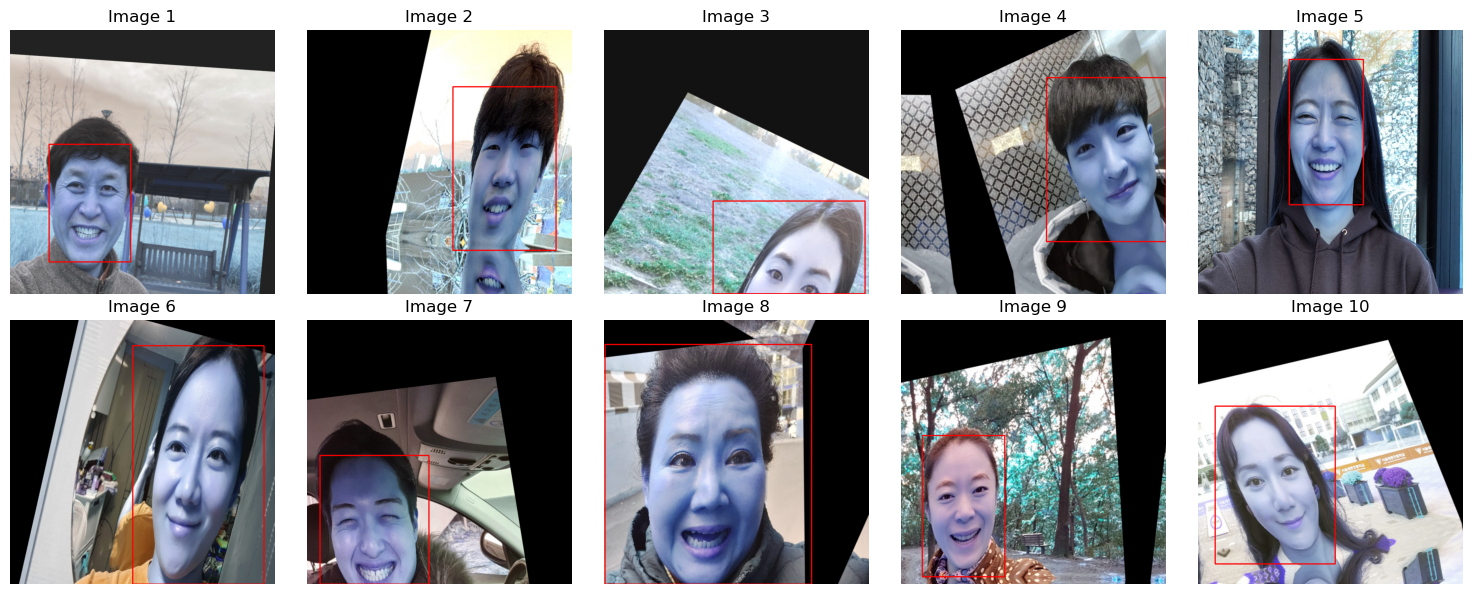

In [14]:
# 이미지와 바운딩 박스 시각화 (증강 데이터)
image_paths = []
boxes = []

for _, row in df_album.head(10).iterrows():
    img_file = row['filename']
    image_path = os.path.join(output_dir, img_file)
    image_paths.append(image_path)

    box_info = {
        'minX': int(row['minX']),
        'minY': int(row['minY']),
        'maxX': int(row['maxX']),
        'maxY': int(row['maxY']),
    }
    boxes.append(box_info)

# 시각화
visualize_images_with_boxes(image_paths, boxes)

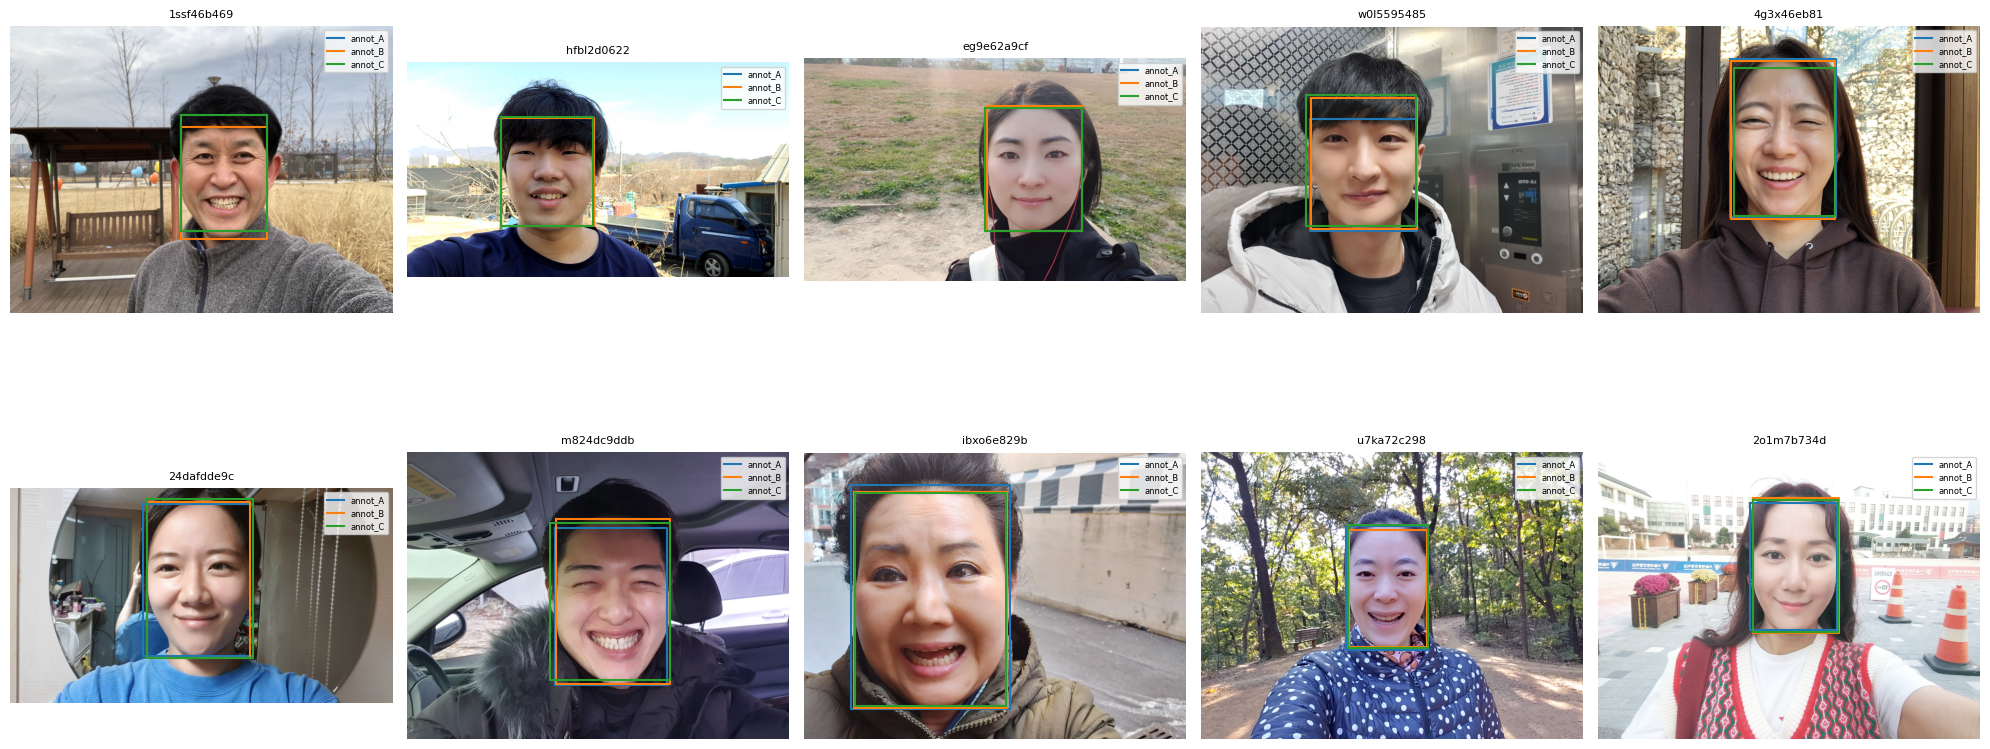

In [15]:
# 이미지와 바운딩 박스 시각화 (원본 데이터)

visualize_boxes(df, img_dir)